In [36]:
import sys
import os
import os.path
import random
import collections
import shutil
import time
import glob
import logging
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.trainer as trainer
import torch.utils.trainer.plugins
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from vqaTools.vqa import VQA
import skimage.io as io
import matplotlib.pyplot as plt
from itertools import islice
import operator

from PIL import Image

# print model

In [37]:
torch.manual_seed(1)
model = models.resnet152(pretrained=True)

In [39]:
use_cuda = True
load_model = False
load_model_num = 2
preprocess = False
test_code = False
epochs = 100
dataset = 'DAQUAR'



if dataset == 'VQA' and preprocess:
    dataDir='./datasets/VQA'
    taskType='OpenEnded'
    dataType='mscoco' # 'mscoco' for real and 'abstract_v002' for abstract
    imgDir = '%s/images/' %(dataDir)
    
    # train
    dataSubType_train='train2017'
    dataImgType_train = 'train2014'
    annFile_train='%s/%s_%s_annotations.json'%(dataDir, dataType, dataSubType_train)
    quesFile_train='%s/%s_%s_%s_questions.json'%(dataDir, taskType, dataType, dataSubType_train)
    
    vqa_train=VQA(annFile_train, quesFile_train)
    
    # val
    dataSubType_val='val2017'
    dataImgType_val = 'val2014'
    annFile_val='%s/%s_%s_annotations.json'%(dataDir, dataType, dataSubType_val)
    quesFile_val='%s/%s_%s_%s_questions.json'%(dataDir, taskType, dataType, dataSubType_val)
    
    vqa_val=VQA(annFile_val, quesFile_val)
    
    # get best 1000 answers
    answer_cnt = {}
    annIds = vqa_train.getQuesIds();  
    anns = vqa_train.loadQA(annIds)
    # annIds = vqa.getQuesIds()
    # anns = vqa.loadQA(annIds)
    for ann in anns:
        ans = ann['answers'][0]
        a = ans['answer']
        word = a.split()[0]
        if word not in answer_cnt:
            answer_cnt[word] = 0
        else:
            answer_cnt[word] += 1

    sorted_answer = sorted(answer_cnt.items(), key=operator.itemgetter(1))
    sorted_answer.reverse()
    sorted_dic = sorted_answer[0:1000]
    # print sorted_dic
    sorted_dic = {i[0]: i[1] for i in sorted_dic}
    quesIds_train = []
    quesIds_val = []
    for ann in anns:
        quesId = ann['question_id']
        ans = ann['answers'][0]
        a = ans['answer']
        word = a.split()[0]
        if word in sorted_dic:
            quesIds_train.append(quesId)
    annIds = vqa_val.getQuesIds()
    anns = vqa_val.loadQA(annIds)
    for ann in anns:
        quesId = ann['question_id']
        ans = ann['answers'][0]
        a = ans['answer']
        word = a.split()[0]
        if word in sorted_dic:
            quesIds_val.append(quesId)
    print len(quesIds_train)
    print len(quesIds_val)
    
    # train
    anns_train = vqa_train.loadQA(quesIds_train)
    
    # val
    anns_val = vqa_val.loadQA(quesIds_val)

loading VQA annotations and questions into memory...
0:00:18.097387
creating index...
index created!
loading VQA annotations and questions into memory...
0:00:07.093713
creating index...
index created!
229155
110550


In [40]:
print sorted_dic

{u'blue': 5376, u'no': 84874, u'1': 12268, u'0': 4639, u'3': 6293, u'2': 12514, u'black': 5907, u'yes': 82676, u'white': 8891, u'red': 5707}


In [22]:
class Affine2D(nn.Module):
    def __init__(self, L, M, N):
        super(Affine2D, self).__init__()
        
        self.weight = nn.Parameter(torch.Tensor(M, N))
        self.bias = nn.Parameter(torch.Tensor(L, N))
        
        self.weight.data.uniform_(-0.1, 0.1)
        self.bias.data.uniform_(-0.1, 0.1)
        
        self.L = L
        self.M = M
        self.N = N
        
    #   expect a 3d tensor : Batch * L * M
    def forward(self, input):
        input = input.contiguous().view(-1, self.M)
        input = torch.mm(input, self.weight)
        input = input.view(-1, self.L, self.N)
        input += self.bias.unsqueeze(0).expand_as(input)
        return input

In [23]:
class BoW(nn.Module):
    def __init__(self, T, N):
        super(BoW, self).__init__()
        
        self.weight = nn.Parameter(torch.Tensor(1, T))
        self.bias = nn.Parameter(torch.Tensor(1, N))
        
        self.weight.data.uniform_(-0.1, 0.1)
        self.bias.data.uniform_(-0.1, 0.1)
        
        self.T = T
        self.N = N
        
    #   expect a 3d sentence tensor : Batch * T * N
    def forward(self, input):
        output = autograd.Variable(torch.FloatTensor(input.size()[0], input.size()[2]))
        if use_cuda:
            output = output.cuda()
        for b in xrange(input.size()[0]):
            output[b, :] = (torch.mm(self.weight, input[b, :, :]) + self.bias).squeeze()
        return output

In [24]:
class SMN(nn.Module):
    def __init__(self, model, hop, L, T, M, N, K, dic_size):
        super(SMN, self).__init__()

        # load resnet
        modules = list(model.children())
        modules.pop()
        modules.pop()
        modules.pop()
        self.features = nn.Sequential(*modules)
        for param in self.features.parameters():
            param.require_grad = False

        self.L = L
        self.T = T
        self.M = M
        self.N = N
        self.K = K
        self.dic_size = dic_size
        
        self.hop = hop
        
        # word embedding
        self.embedding = nn.Embedding(self.dic_size, self.N)
        self.rnn = nn.LSTM(N, N, 1)

        # LSTM parameters
        self.h0 = nn.Parameter(torch.Tensor(1, 32, N))
        self.c0 = nn.Parameter(torch.Tensor(1, 32, N))
        
        self.h0.data.uniform_(-0.1, 0.1)
        self.c0.data.uniform_(-0.1, 0.1)
        
        self.attention = Affine2D(self.L, self.M, self.N)
        self.evidence = Affine2D(self.L, self.M, self.N)
        self.BoW = BoW(self.T, self.N)
        self.linear = nn.Linear(self.N, self.K)
        
        
    def forward(self, img, question):
        #   extract features from resNet
        S = self.features(img)
        
        # embedding
        V = self.embedding(question)
        
        # LSTM
        V = self.rnn(V, (self.h0, self.c0))
        
        #   word attention
        S = ((S.view(-1, self.M, self.L)).permute(0, 2, 1))
        att = self.attention(S)
        
        batch_size = att.size()[0]
        C = autograd.Variable(torch.FloatTensor(batch_size, self.T, self.L))
        if use_cuda:
            C = C.cuda()
        for b in xrange(batch_size):
            C[b, :, :] = torch.mm(V[b, :, :], att.transpose(1, 2)[b, :, :])

        # C : Batch * T * L
        W_att = nn.Softmax()(torch.squeeze(torch.max(C, 1)[0], 1)).unsqueeze(1)
    
        # evidence * attention
        evid = self.evidence(S)
        S_att = autograd.Variable(torch.FloatTensor(batch_size, self.N))
        if use_cuda:
            S_att = S_att.cuda()
        for b in xrange(batch_size):
            S_att[b, :] = torch.mm(W_att[b, :, :], evid[b, :, :]).squeeze()
        
        Q = self.BoW(V)
        
        if self.hop == 1:    
            # 1-hop output
            P = nn.LogSoftmax()(self.linear(nn.ReLU()(S_att + Q)))
        elif self.hop == 2:
            O_hop1 = S_att + Q
            C_hop2 = autograd.Variable(torch.FloatTensor(batch_size, self.L))
            if use_cuda:
                C_hop2 = C_hop2.cuda()
            for b in xrange(batch_size):
                C_hop2[b, :] = torch.mm(evid[b, :, :], O_hop1[b, :].unsqueeze(1)).squeeze()
            
            W_att2 = nn.Softmax()(C_hop2).unsqueeze(1)
            evid2 = self.evidence(S)
            self.S_att2 = autograd.Variable(torch.FloatTensor(batch_size, self.N))
            if use_cuda:
                self.S_att2 = self.S_att2.cuda()
            for b in xrange(batch_size):
                self.S_att2[b, :] = torch.mm(W_att2[b, :, :], evid2[b, :, :]).squeeze()
            
            P = nn.LogSoftmax()(self.linear(nn.ReLU()(O_hop1 + self.S_att2)))
        return P

In [25]:
if preprocess:
    stc_idx_to_img_name = {}
    question_word_to_idx = {'UNK': 0, 'END': 1}
    answer_word_to_idx = {'UNK': 0}

    if dataset == 'DAQUAR':
        # read txt questions and answers
        f = open('./datasets/DAQUAR/texts/train/train.txt', 'r')

        # preload
        is_question = True
        line = f.readline()
        max_len = 0
        cnt = 0
        while line != '':
            if is_question:
                cnt = cnt + 1
                if len(line.split()[:-4]) > max_len:
                    max_len = len(line.split()[:-4])
                for word in line.split()[:-4]:
                    if word not in question_word_to_idx:
                        question_word_to_idx[word] = len(question_word_to_idx)
            else:
                word = line.split()[0]
                if word not in answer_word_to_idx:
                    answer_word_to_idx[word] = len(answer_word_to_idx)
            line = f.readline()
            is_question = not is_question


        # reload, add padding and convert into integers
        f.seek(0)
        line = f.readline()
        train_q = torch.LongTensor(cnt, max_len).zero_() + 1
        train_a = torch.LongTensor(cnt)
        train_img_names = []
        idx = 0
        while line != '':
            if is_question:
                q = line.split()[:-4]
                train_img_names.append(line.split()[-2] + '.png')
                for i in xrange(len(q)):
                    train_q[idx, i] = question_word_to_idx[q[i]]
            else:
                word = line.split()[0]
                train_a[idx] = answer_word_to_idx[word]
                idx = idx + 1
            line = f.readline()
            is_question = not is_question

        f.close()
    elif dataset == 'VQA':
        max_len = 0
        train_img_names = []
        for ann in anns_train:
            quesId = ann['question_id']
            q = vqa_train.qqa[quesId]['question']
            q = q.split()
            for word in q:
                if word not in question_word_to_idx:
                    question_word_to_idx[word] = len(question_word_to_idx)
            ans = ann['answers'][0]
            a = ans['answer']
            word = a.split()[0]
            if word not in answer_word_to_idx:
                answer_word_to_idx[word] = len(answer_word_to_idx)
            if len(q) > max_len:
                max_len = len(q)
            
            imgId = ann['image_id']
            imgFilename = 'COCO_' + dataImgType_train + '_'+ str(imgId).zfill(12) + '.jpg'
            train_img_names.append(imgFilename)
                
        train_q = torch.LongTensor(len(anns_train), max_len).zero_() + 1
        train_a = torch.LongTensor(len(anns_train))
        
        idx = 0
        for ann in anns_train:
            quesId = ann['question_id']
            q = vqa_train.qqa[quesId]['question']
            q = q.split()
            for i in xrange(len(q)):
                train_q[idx, i] = question_word_to_idx[q[i]]
            ans = ann['answers'][0]
            a = ans['answer']
            word = a.split()[0]
            train_a[idx] = answer_word_to_idx[word]
            idx = idx + 1
            
    torch.save(max_len, './datasets/%s/max_len' % dataset)
    torch.save(question_word_to_idx, './datasets/%s/question_word_to_idx' % dataset)
    torch.save(answer_word_to_idx, './datasets/%s/answer_word_to_idx' % dataset)
    torch.save(train_q, './datasets/%s/texts/train/train_q' % dataset)
    torch.save(train_a, './datasets/%s/texts/train/train_a' % dataset)
    torch.save(train_img_names, './datasets/%s/texts/train/train_img_names' % dataset)
else:
    max_len = torch.load('./datasets/%s/max_len' % dataset)
    question_word_to_idx = torch.load('./datasets/%s/question_word_to_idx' % dataset)
    answer_word_to_idx = torch.load('./datasets/%s/answer_word_to_idx' % dataset)
    train_q = torch.load('./datasets/%s/texts/train/train_q' % dataset)
    train_a = torch.load('./datasets/%s/texts/train/train_a' % dataset)
    train_img_names = torch.load('./datasets/%s/texts/train/train_img_names' % dataset)

# print max_len
# print len(question_word_to_idx)
# print torch.max(train_q)
# print len(train_img_names)
# print len(answer_word_to_idx)

# print cnt

In [26]:
print max_len
print train_q.size()
print train_a.size()
print len(question_word_to_idx)

20
torch.Size([47549, 20])
torch.Size([47549])
9517


In [27]:
if preprocess:
    if dataset == 'DAQUAR':
        f = open('./datasets/DAQUAR/texts/val/val.txt', 'r')

        cnt = 0
        line = f.readline()
        while line != '':
            cnt = cnt + 1
            line = f.readline()

        cnt /= 2
        f.seek(0)
        line = f.readline()
        val_q = torch.LongTensor(cnt, max_len).zero_() + 1
        val_a = torch.LongTensor(cnt)
        val_img_names = []
        idx = 0
        is_question = True
        while line != '':
            if is_question:
                q = line.split()[:-4]
                val_img_names.append(line.split()[-2] + '.png')
                for i in xrange(len(q)):
                    if q[i] not in question_word_to_idx:
                        val_q[idx, i] = 0
                    else:
                        val_q[idx, i] = question_word_to_idx[q[i]]
            else:
                word = line.split()[0]
                if word not in answer_word_to_idx:
                    val_a[idx] = 0
                else:
                    val_a[idx] = answer_word_to_idx[word]
                idx = idx + 1
            line = f.readline()
            is_question = not is_question

        f.close()
    elif dataset == 'VQA':
        idx = 0
        val_q = torch.LongTensor(len(anns_val), max_len).zero_() + 1
        val_a = torch.LongTensor(len(anns_val))
        val_img_names = []
        for ann in anns_val:
            quesId = ann['question_id']
            q = vqa_val.qqa[quesId]['question']
            q = q.split()
            for i in xrange(len(q)):
                if i >= max_len:
                    continue
                if q[i] not in question_word_to_idx:
                    val_q[idx, i] = 0
                else:
                    val_q[idx, i] = question_word_to_idx[q[i]]
            ans = ann['answers'][0]
            a = ans['answer']
            word = a.split()[0]
            if word not in answer_word_to_idx:
                val_a[idx] = 0
            else:
                val_a[idx] = answer_word_to_idx[word]
                
            imgId = ann['image_id']
            imgFilename = 'COCO_' + dataImgType_val + '_'+ str(imgId).zfill(12) + '.jpg'
            val_img_names.append(imgFilename)
            
            idx = idx + 1
            
    torch.save(val_q, './datasets/%s/texts/val/val_q' % dataset)
    torch.save(val_a, './datasets/%s/texts/val/val_a' % dataset)
    torch.save(val_img_names, './datasets/%s/texts/val/val_img_names' % dataset)
else:
    val_q = torch.load('./datasets/%s/texts/val/val_q' % dataset)
    val_a = torch.load('./datasets/%s/texts/val/val_a' % dataset)
    val_img_names = torch.load('./datasets/%s/texts/val/val_img_names' % dataset)
# print cnt


In [28]:
print val_q.size()
print val_a.size()

torch.Size([24147, 20])
torch.Size([24147])


In [29]:
if not load_model:
    smn_model = SMN(model, 
                    2,
                    L=14*14, 
                    T=max_len, 
                    M=1024, 
                    N=512, 
                    K=len(answer_word_to_idx), 
                    dic_size=len(question_word_to_idx)
                    )
else:
    smn_model = torch.load('model/%s/model.%dth' % (dataset, load_model_num))

if use_cuda:
    smn_model = torch.nn.DataParallel(smn_model).cuda()

In [30]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, root, questions, answers, imgs, transform=None):
        super(VQADataset, self).__init__()
        self.root = root
        self.questions = questions
        self.answers = answers
        self.imgs = imgs
        self.transform = transform
        
    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        img = img.resize((224, 224))
        if self.transform is not None:
            img = self.transform(img)
        
        if self.transform is not None and img.size()[0] != 3:
            print "GRAY IMAGE! CONVERTED INTO RGB"
            img = torch.cat((img, img, img), 0)
        return img, self.questions[index], self.answers[index]

    def __len__(self):
        return len(self.answers)

In [31]:
train_data = VQADataset('./datasets/%s/images' % dataset,
                          train_q,
                          train_a,
                          train_img_names,
                          transforms.Compose([
#                                 transforms.Scale([224, 224]),
#                                 transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])
                            ])
                         )
val_data = VQADataset('./datasets/%s/images' % dataset,
                          val_q,
                          val_a,
                          val_img_names,
                          transforms.Compose([
#                                 transforms.Scale([224, 224]),
#                                 transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])
                            ])
                         )

# print train_data.__getitem__(2)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=8, shuffle=True)

In [14]:
class AverageLogger:
    def __init__(self):
        self.N = 0
        self.val = 0.
        self.avg = 0.
    def update(self, val, n=1):
        self.val += val
        self.N += n
        self.avg = self.val / self.N
    def getAverage(self):
        return self.avg
    

In [15]:
def accuracy(pred, target):
    pred_max, indices = torch.sort(pred, dim=1, descending=True)
    indices = torch.squeeze(indices[:, 0])
    return float((indices == target).sum())
    

In [16]:
def train(train_loader, model, criterion, optimizer, epoch):
    losses = AverageLogger()
    acc = AverageLogger()
    
    # switch to train mode
    model.train()
    
    old_time= time.time()
    epoch_start = old_time
    for i, (images, questions, target) in enumerate(train_loader):
        if use_cuda:
            target = target.cuda(async=True)

        # compute y_pred
        y_pred = model(autograd.Variable(images), autograd.Variable(questions))
        loss = criterion(y_pred, autograd.Variable(target))
        
        # measure accuracy and record loss
#         print y_pred.size()
#         print target.size()
        pred_acc = accuracy(y_pred.data, target)
        losses.update(loss.data[0], y_pred.size(0))
        acc.update(pred_acc, y_pred.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
#         print model.attention.weight.grad.sum()
        optimizer.step()
        
        new_time = time.time()
#         print "Batch %d's time: %.3f s" % (i, new_time - old_time)
        old_time = new_time
        if test_code:
            break
        else:
            pass
    if not test_code:
        f.write("Epoch %d: Training Losses: %.3f, Training Accuracy: %.3f, Time: %.3f s\n" \
          % (epoch, losses.getAverage(), acc.getAverage(), time.time() - epoch_start))

In [ ]:
def val(val_loader, model, critertion, epoch):
    losses = AverageLogger()
    acc = AverageLogger()
    
    # switch to train mode
    model.eval()
    
    old_time= time.time()
    epoch_start = old_time
    for i, (images, questions, target) in enumerate(val_loader):
        if use_cuda:
            target = target.cuda(async=True)

        # compute y_pred
        y_pred = model(autograd.Variable(images), autograd.Variable(questions))
        loss = criterion(y_pred, autograd.Variable(target))
        
        # measure accuracy and record loss
        pred_acc = accuracy(y_pred.data, target)
        losses.update(loss.data[0], y_pred.size(0))
        acc.update(pred_acc, y_pred.size(0))
        
        new_time = time.time()
#         print "Batch %d's time: %.3f s" % (i, new_time - old_time)
        old_time = new_time
        if test_code:
            break
        else:
            pass
    if not test_code:
        f.write("Epoch %d: Validation Losses: %.3f, Validation Accuracy: %.3f, Time: %.3f s\n" \
          % (epoch, losses.getAverage(), acc.getAverage(), time.time() - epoch_start))

In [ ]:

if not test_code:
    f = open('log_%s.txt' % dataset, 'w+')

criterion = nn.NLLLoss()
if use_cuda:
    criterion = criterion.cuda()
# add L2 penalty for DAQUAR
optimizer = torch.optim.Adam(smn_model.parameters(), weight_decay=(0.01 if dataset == 'DAQUAR' else 0))

for epoch in xrange(epochs):
    train(train_loader, smn_model, criterion, optimizer, epoch)
    val(val_loader, smn_model, criterion, epoch)
    # save model
    if not test_code:
        torch.save(smn_model, "model/%s/model.%dth" % (dataset, epoch))
    
if not test_code:
    f.close()


  7183
     0
  6396
  ⋮   
 13426
  3567
  2722
[torch.LongTensor of size 24147]



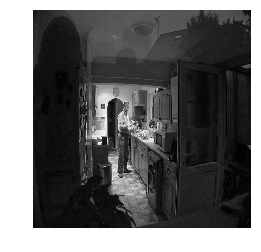

Question: What time was this picture taken? END END END END END END END END END END END END END END
Ground Truth: 8:30
Predicted: lawver/barrett


In [34]:
test_idx = 130

print val_a
test_data = VQADataset('./datasets/%s/images' % dataset,
                          val_q,
                          val_a,
                          val_img_names)
img, q, a = test_data[test_idx]
img_feed, q_feed, _ = val_data[test_idx]
# print question_word_to_idx[1]
question_idx_to_word = {idx : word for word, idx in question_word_to_idx.iteritems()}
answer_idx_to_word = {idx : word for word, idx in answer_word_to_idx.iteritems()}
# print answer_word_to_idx
# plt.imshow(img)
# plt.axis('off')
# plt.show()
# print question_idx_to_word
q = ' '.join([question_idx_to_word[w] for w in q])
a = answer_idx_to_word[a]
img = np.array(img)
# img = np.reshape(img, (224, 224, 3))
# img = np.swapaxes(img, 0, 2)
# img = np.swapaxes(img, 0, 1)
# print img.shape
plt.imshow(img)
plt.axis('off')
plt.show()
print "Question: " + q
print "Ground Truth: " + a


img_feed = torch.unsqueeze(img_feed, 0)
q_feed = torch.unsqueeze(q_feed, 0)
# print img_feed.size(), q_feed.size()
y_pred = smn_model(autograd.Variable(img_feed), autograd.Variable(q_feed))
_, indices = torch.max(y_pred[0], 0)
print "Predicted: " + answer_idx_to_word[indices.cpu().data[0]]

In [59]:
a = 1
torch.save(a, './model/a')